In [ ]:
import sys
import os
sys.path.append('../src')

from sentiment import preprocess_text, get_sentiment, get_vader_sentiment, analyze_sentiment_keywords

import pandas as pd

In [ ]:
#import dependencies
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns


#sentiment analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#keyword Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#visuals
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

In [ ]:
import pandas as pd
import oracledb
import matplotlib.pyplot as plt
import seaborn as sns


connection = oracledb.connect(user="system", password="system", dsn="localhost:1521/XE")

query = """
SELECT r.review_text, r.rating, r.review_date, b.bank_name, r.sentiment_score 
FROM reviews r
JOIN banks b ON r.bank_id = b.bank_id
"""

df = pd.read_sql(query, connection)

# Normalize column names
df.columns = df.columns.str.lower()

# Convert LOB to string WHILE connection is still open
df['review_text'] = df['review_text'].apply(lambda x: x.read() if hasattr(x, 'read') else str(x))

# Now close the connection
connection.close()

# Continue with your calculations
df['char_length'] = df['review_text'].apply(len)
df['word_count'] = df['review_text'].apply(lambda x: len(x.split()))

In [ ]:
# Enhance sentiment analysis if not already in data
def enhanced_sentiment(text):
    analysis = TextBlob(str(text))
    # Compound score considering both polarity and subjectivity
    return analysis.sentiment.polarity * (1 + analysis.sentiment.subjectivity/2)

if 'sentiment_score' not in df.columns or df['sentiment_score'].isnull().all():
    df['sentiment_score'] = df['review_text'].apply(enhanced_sentiment)

# Categorize sentiment
df['sentiment_category'] = pd.cut(df['sentiment_score'],
                                 bins=[-1, -0.1, 0.1, 1],
                                 labels=['Negative', 'Neutral', 'Positive'])

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='bank_name', hue='sentiment_category', 
             order=df['bank_name'].value_counts().index)
plt.title('Sentiment Distribution Across Banks', fontsize=14)
plt.xlabel('Bank', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('../viewdata/sentiment_by_bank.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='rating', y='sentiment_score', palette='viridis')
plt.title('Sentiment Scores by Star Rating', fontsize=14)
plt.xlabel('Star Rating (1-5)', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.savefig('../viewdata/rating_vs_sentiment.png', dpi=300)
plt.show()



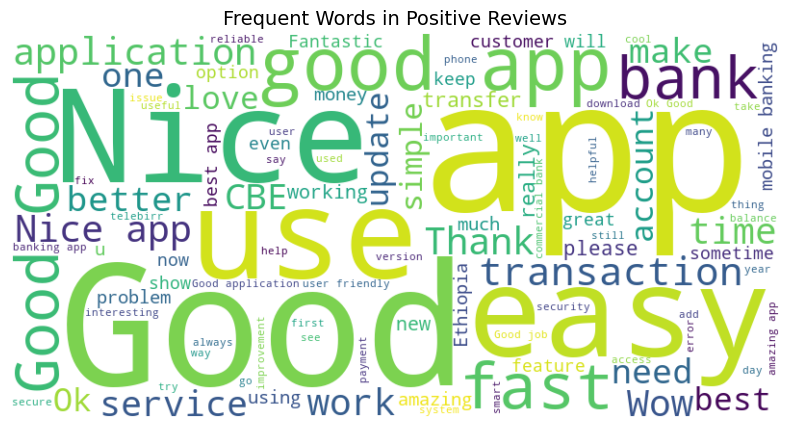

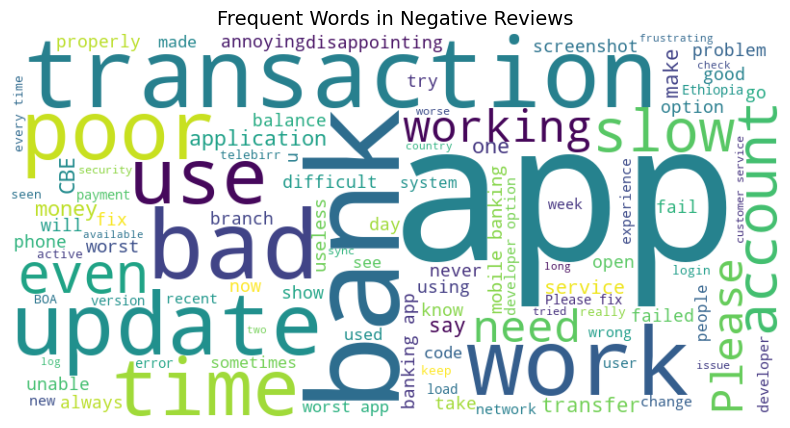

In [28]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap='viridis',
                         max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    return plt

# Positive reviews
positive_text = ' '.join(df[df['sentiment_category'] == 'Positive']['review_text'])
generate_wordcloud(positive_text, 'Frequent Words in Positive Reviews').savefig('../viewdata/wordcloud_positive.png', dpi=300)

# Negative reviews
negative_text = ' '.join(df[df['sentiment_category'] == 'Negative']['review_text'])
generate_wordcloud(negative_text, 'Frequent Words in Negative Reviews').savefig('../viewdata/wordcloud_negative.png', dpi=300)

In [29]:
# Analyze most common phrases
from collections import Counter
import re

def extract_keyphrases(text_series, n=3):
    phrases = []
    for text in text_series:
        words = re.findall(r'\w+', text.lower())
        phrases.extend([' '.join(words[i:i+n]) for i in range(len(words)-n+1)])
    return Counter(phrases).most_common(20)

# Positive drivers
positive_phrases = extract_keyphrases(df[df['sentiment_category'] == 'Positive']['review_text'])
print("\nTop Positive Phrases:")
for phrase, count in positive_phrases[:10]:
    print(f"{phrase}: {count}")

# Negative pain points
negative_phrases = extract_keyphrases(df[df['sentiment_category'] == 'Negative']['review_text'])
print("\nTop Negative Phrases:")
for phrase, count in negative_phrases[:10]:
    print(f"{phrase}: {count}")

# Bank comparison
bank_stats = df.groupby('bank_name').agg({
    'rating': 'mean',
    'sentiment_score': 'mean',
    'review_text': 'count'
}).sort_values('rating', ascending=False)
print("\nBank Comparison:")
print(bank_stats)


Top Positive Phrases:
easy to use: 173
this app is: 67
it is good: 67
it s good: 66
and easy to: 56
the app is: 54
i love it: 50
it doesn t: 48
to use and: 46
i like it: 40

Top Negative Phrases:
doesn t work: 25
it doesn t: 22
it s not: 19
this app is: 19
the app is: 15
i can t: 14
i don t: 13
mobile banking app: 12
it is not: 12
to go to: 12

Bank Comparison:
                               rating  sentiment_score  review_text
bank_name                                                          
Dashen Bank                  4.101833         0.484345          491
Commercial Bank of Ethiopia  4.053214         0.463876         7498
Bank of Abyssinia            3.063218         0.211142         1044
